In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
import os
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torchvision import datasets, models
from torchsummary import summary
from tqdm import tqdm
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from datetime import datetime
from pathlib import Path
from PIL import Image
from google.colab import files


In [2]:
DATA_DIR = r'../content/drive/MyDrive/NEW DS'

In [3]:
# Get filepaths and labels
image_dir = Path(DATA_DIR)
filepaths = list(image_dir.glob(r'**/*.jpg'))
labels = list(map(lambda x: os.path.split(os.path.split(x)[0])[1], filepaths))

filepaths = pd.Series(filepaths, name='Filepath').astype(str)
labels = pd.Series(labels, name='Label')

label_encoder = {'nerva': 0, 'hadrian': 1, 'titus': 2, 'trajan': 3, 'antoninus': 4, 'lucius': 5, 'vespasian': 6, 'domitian': 7, 'marcus': 8}

print(label_encoder)
# Concatenate filepaths and labels
image_df = pd.concat([filepaths, labels], axis=1)
image_df.replace(label_encoder,inplace=True)

{'nerva': 0, 'hadrian': 1, 'titus': 2, 'trajan': 3, 'antoninus': 4, 'lucius': 5, 'vespasian': 6, 'domitian': 7, 'marcus': 8}


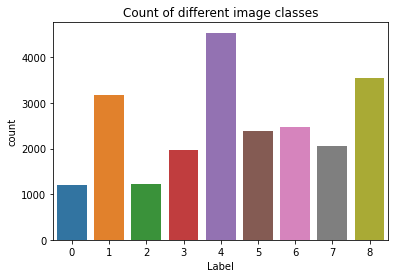

In [4]:
sns.countplot(x='Label', data=image_df).set(title='Count of different image classes')
plt.show()

In [5]:
#dataset for the coins
class CoinDataset(Dataset):
  def __init__(self, images, labels, transform = None):
    self.images = images
    self.labels = labels
    self.transform = transform

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    img = Image.open(self.images.iloc[idx])
    if self.transform:
      img = self.transform(img)
      label = torch.tensor(self.labels.iloc[idx])
    return img, label

In [6]:
#returns each one of the data loaders for train validation and test
def get_loaders(train, train_labels, val, val_labels,test, test_labels, batch_size, train_transform, test_transform):

  train_ds = CoinDataset(images = train, labels = train_labels, transform = train_transform)
  val_ds = CoinDataset(images = val, labels = val_labels, transform = test_transform)
  test_ds = CoinDataset(images = test, labels = test_labels, transform = test_transform)

  train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle= True)
  val_loader = DataLoader(val_ds, batch_size=batch_size,shuffle= False)
  test_loader = DataLoader(test_ds, batch_size=batch_size,shuffle= False)

  return train_loader, val_loader, test_loader

In [7]:
#mean and std by resnet for transformers
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

In [10]:
#resizing the images to the same size, rotating te images to range of (-10,10) degrees,and normalize 
Train_transform = transforms.Compose([
        transforms.Resize((280, 280)),
        transforms.RandomCrop(size=(256, 256)),
        transforms.ColorJitter(brightness=.5, hue=.3),
        transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 0.2)),
        transforms.RandomRotation(degrees = 25),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

In [11]:
#resizing the test set
Test_transform = transforms.Compose([
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean, std)
])

In [12]:
train,test, train_labels, test_labels = train_test_split(image_df.Filepath, image_df.Label, test_size=0.2, shuffle=True)
train,validation, train_labels, validation_labels = train_test_split(train, train_labels, test_size=0.2, shuffle=True)

In [13]:
# class weights for imbalanced data set
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                 classes = np.unique(train_labels),
                                                 y =train_labels)
class_weights = torch.FloatTensor(class_weights).cuda()
class_weights

tensor([2.0796, 0.7863, 2.0556, 1.2526, 0.5538, 1.0653, 1.0364, 1.1850, 0.7094],
       device='cuda:0')

In [14]:
batch_size = 32
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [15]:
train_loader, val_loader, test_loader = get_loaders(train,train_labels,validation, validation_labels, test,test_labels, batch_size,
                                                    Train_transform, Test_transform)

In [16]:
# Define the model (resent18)
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:209: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  f"The parameter '{pretrained_param}' is deprecated since 0.13 and will be removed in 0.15, "
/usr/local/lib/python3.7/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [ ]:
model.fc

Linear(in_features=512, out_features=1000, bias=True)

In [17]:
in_featuers = model.fc.in_features

In [18]:
model.fc = nn.Linear(in_featuers, 9)

In [ ]:
model.to(device)

In [ ]:
summary(model, (3, 256, 256))

In [20]:
# Loss and optimizer
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(model.parameters())

In [ ]:
# # check point
# state_dict = torch.load('/content/drive/MyDrive/Colab Notebooks/emp_model_cpoint10.pth')
# model.load_state_dict(state_dict)

<All keys matched successfully>

In [ ]:
# # old losses, for plotting
# train_losses = [1.90556544, 1.46553168, 1.24558555, 1.12891949, 1.03373565, 0.9662883, 0.90644638, 0.86894401, 0.84078352, 0.80325387, 0.77904942]
# val_losses = [1.60601752, 1.29182064, 1.15274073, 1.08791918, 0.9629088,  0.94613657, 0.86127839, 0.8614954,  0.87530397, 0.83612262, 0.77601643]

In [22]:
epochs = 20

train_losses = [] #np.zeros(epochs)
val_losses = [] #np.zeros(epochs)
check_point = 'emp_model_cpoint'
for it in range(epochs):
  t0 = datetime.now()
  train_loss = []
  for inputs, targets in train_loader:
      # move data to GPU
    inputs, targets = inputs.to(device), targets.to(device)

      # zero the parameter gradients
    optimizer.zero_grad()

      # Forward pass
    outputs = model(inputs)
    loss = criterion(outputs, targets)
        
      # Backward and optimize
    loss.backward()
    optimizer.step()

    train_loss.append(loss.item())

    # Get train loss and test loss
  train_loss = np.mean(train_loss) 

  #Saves model weights 
  torch.save(model.state_dict(), check_point+'_256_low_rotation_crop_'+str(it+1)+'.pth')  
  val_loss = []
  for inputs, targets in val_loader:
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    loss = criterion(outputs, targets)
    val_loss.append(loss.item())
  val_loss = np.mean(val_loss)

    # Save losses
  train_losses.append(train_loss)
  val_losses.append(val_loss)
  
  dt = datetime.now() - t0
  print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
    Validation Loss: {val_loss:.4f}, Duration: {dt}')

Epoch 1/20, Train Loss: 1.1270,     Validation Loss: 0.6662, Duration: 1:12:19.455270
Epoch 2/20, Train Loss: 0.6355,     Validation Loss: 0.6309, Duration: 0:05:09.844296
Epoch 3/20, Train Loss: 0.5538,     Validation Loss: 0.5356, Duration: 0:05:11.682265
Epoch 4/20, Train Loss: 0.4793,     Validation Loss: 0.5000, Duration: 0:05:17.255456
Epoch 5/20, Train Loss: 0.4375,     Validation Loss: 0.4709, Duration: 0:05:14.490336
Epoch 6/20, Train Loss: 0.4121,     Validation Loss: 0.4440, Duration: 0:05:08.355836
Epoch 7/20, Train Loss: 0.3603,     Validation Loss: 0.4986, Duration: 0:05:08.750696
Epoch 8/20, Train Loss: 0.3446,     Validation Loss: 0.4589, Duration: 0:05:07.031045
Epoch 9/20, Train Loss: 0.3223,     Validation Loss: 0.4650, Duration: 0:05:07.818936
Epoch 10/20, Train Loss: 0.3143,     Validation Loss: 0.4424, Duration: 0:05:07.887791
Epoch 11/20, Train Loss: 0.2843,     Validation Loss: 0.4577, Duration: 0:05:06.912529
Epoch 12/20, Train Loss: 0.2595,     Validation Loss

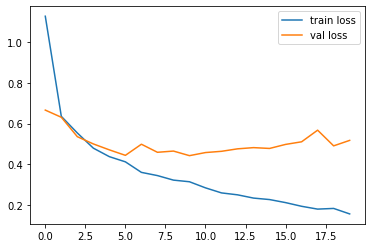

In [23]:
# Plot the train loss and val loss per iteration
plt.plot(train_losses, label='train loss')
plt.plot(val_losses, label='val loss')
plt.legend()
plt.show()

In [ ]:
for i in zip(train_losses, val_losses):
  print(i)

In [27]:
# load best model
state_dict = torch.load('/content/emp_model_cpoint_256_low_rotation_crop_10.pth')
model.load_state_dict(state_dict)

<All keys matched successfully>

In [28]:
# Accuracy
with torch.no_grad():
  model.eval()
  n_correct = 0.
  n_total = 0.
  for inputs, targets in train_loader:
    inputs, targets = inputs.to(device), targets.to(device)

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)
    
    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

  train_acc = n_correct / n_total


  n_correct = 0.
  n_total = 0.
  for inputs, targets in test_loader:
    inputs, targets = inputs.to(device), targets.to(device)

    # Forward pass
    outputs = model(inputs)

    # Get prediction
    # torch.max returns both max and argmax
    _, predictions = torch.max(outputs, 1)
    
    # update counts
    n_correct += (predictions == targets).sum().item()
    n_total += targets.shape[0]

  test_acc = n_correct / n_total
  print(f"Train acc: {train_acc:.4f}, Test acc: {test_acc:.4f}")

Train acc: 0.9128, Test acc: 0.8634


In [29]:
nb_classes = 9
confusion_matrix = np.zeros((nb_classes, nb_classes))
with torch.no_grad():
    for i, (inputs, targets) in enumerate(test_loader):
        inputs, targets = inputs.to(device), targets.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        for t, p in zip(targets.view(-1), preds.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

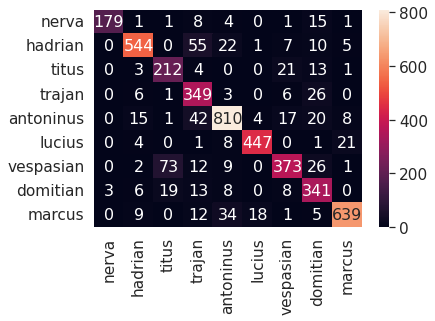

In [30]:
df_cm = pd.DataFrame(confusion_matrix, range(nb_classes), range(nb_classes))
sns.set(font_scale=1.4) # for label size
sns.heatmap(df_cm, annot=True, annot_kws={"size": 16}, fmt='g',xticklabels=label_encoder, yticklabels=label_encoder)
plt.show()